In [1]:
!pip install --quiet evaluate

In [2]:
!pip install -q segmentation-models-pytorch

import os
import time
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from scipy.ndimage.morphology import binary_dilation


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-2-81ad44532638>:28: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


#### Set device to cuda

In [3]:
# prompt: set device to use GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
import torch
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Assigned GPU: {gpu_name}")
else:
    print("No GPU available.")


No GPU available.


# Data Preprocessing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Get all files

In [7]:
files_dir = '/content/drive/MyDrive/Classification/Training'
file_paths = glob(f'{files_dir}/*[0-9].jpg')

In [8]:
file_paths[0]

'/content/drive/MyDrive/Classification/Training/Tr-pi_0502.jpg'

## Dataset Class

### Classification

In [9]:
class BrainTumorClassificationDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]

    def get_label_from_folder(self, folder_name):
        if 'pi' in folder_name.lower():
            return 0  # pituitary
        elif 'no' in folder_name.lower():
            return 1  # no_tumor
        elif 'gl' in folder_name.lower():
            return 2  # glioma
        elif 'me' in folder_name.lower():
            return 3  # meningioma
        else:
            return 4  # unknown

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        label = self.get_label_from_folder(filename)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = np.array(image.resize((128, 128)))  # Resize and convert to NumPy array
        image = image.flatten() / 255.0  # Flatten and normalize pixel values

        return image, label

# Path to your main "Training" directory
image_dir = "/content/drive/MyDrive/Classification/Training"

# Load dataset
classification_dataset = BrainTumorClassificationDataset(image_dir=image_dir) #transform=classification_transform)

# Split the dataset into training (80%) and evaluation (20%)
train_size = int(0.8 * len(classification_dataset))  # 80% for training
eval_size = len(classification_dataset) - train_size  # The rest for evaluation
train_dataset, eval_dataset = random_split(classification_dataset, [train_size, eval_size])


# Create DataLoaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)


# Example of how to access data from the DataLoader
for batch in train_loader:
    # Unpack the batch into images and labels
    images, labels = batch

    # Now iterate through each image and label in the batch
    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        # Process image and label
        print(image.shape)
        print(label)


Streaming output truncated to the last 5000 lines.
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(3)
torch.Size([16384])
tensor(2)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(3)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(2)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(3)
torch.Size([16384])
tensor(2)
torch.Size([16384])
tensor(1)
torch.Size([16384])
tensor(2)
torch.Size([16384])
tensor(0)
torch.Size([16384])
tensor(2)
torch.Size([16384])
tensor(3)
torch.Size([16384])
tensor(3)
torch.Size([16384])
tensor(1)
torch.Size([16384])

# load dateset split for svm

In [10]:
# Path to your dataset
image_dir = "/content/drive/MyDrive/Classification/Training"

# Dataset loading
classification_dataset = BrainTumorClassificationDataset(image_dir=image_dir)

# Extract features and labels
features = []
labels = []

for i in range(len(classification_dataset)):
    feature, label = classification_dataset[i]  # Get processed image and label
    features.append(feature)
    labels.append(label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Check the shapes of features and labels
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of training and validation sets
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# Create an SVM pipeline with normalization
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale', probability=True))

# Train the SVM model
svm.fit(X_train, y_train)

# Predict on the validation set
y_pred = svm.predict(X_val)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Overall accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")


Features shape: (5712, 16384), Labels shape: (5712,)
Training data shape: (4569, 16384), Validation data shape: (1143, 16384)
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       292
           1       0.92      0.96      0.94       319
           2       0.87      0.82      0.84       264
           3       0.80      0.77      0.79       268

    accuracy                           0.89      1143
   macro avg       0.88      0.88      0.88      1143
weighted avg       0.88      0.89      0.88      1143

Validation Accuracy: 0.89


# TESTING DATASET

In [11]:
image_dir_test = "/content/drive/MyDrive/Classification/Testing"

In [12]:
def preprocess_test_images(image_dir_test):
    features = []
    image_names = []

    for image_name in os.listdir(image_dir_test):
        # Skip non-image files
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image_path = os.path.join(image_dir_test, image_name)
        try:
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = np.array(image.resize((128, 128)))  # Resize to 128x128
            features.append(image.flatten() / 255.0)  # Flatten and normalize
            image_names.append(image_name)
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

    return np.array(features), image_names

# Preprocess the testing dataset
X_test, test_image_names = preprocess_test_images(image_dir_test)
print(f"Testing Features Shape: {X_test.shape}")



Testing Features Shape: (1311, 16384)


In [13]:
# Scale the testing features using the same scaler from training
X_test_scaled = svm.named_steps['standardscaler'].transform(X_test)


In [14]:
# Predict labels for the testing dataset
y_test_pred = svm.named_steps['svc'].predict(X_test_scaled)

# Print predictions
for img_name, pred in zip(test_image_names, y_test_pred):
    print(f"Image: {img_name}, Predicted Class: {pred}")


Image: Te-me_0117.jpg, Predicted Class: 3
Image: Te-me_0156.jpg, Predicted Class: 3
Image: Te-me_0195.jpg, Predicted Class: 3
Image: Te-no_0140.jpg, Predicted Class: 1
Image: Te-me_0135.jpg, Predicted Class: 3
Image: Te-me_0058.jpg, Predicted Class: 3
Image: Te-no_0080.jpg, Predicted Class: 1
Image: Te-no_0095.jpg, Predicted Class: 2
Image: Te-me_0119.jpg, Predicted Class: 2
Image: Te-no_0021.jpg, Predicted Class: 1
Image: Te-meTr_0002.jpg, Predicted Class: 1
Image: Te-gl_0025.jpg, Predicted Class: 2
Image: Te-me_0301.jpg, Predicted Class: 3
Image: Te-gl_0218.jpg, Predicted Class: 2
Image: Te-no_0127.jpg, Predicted Class: 1
Image: Te-gl_0177.jpg, Predicted Class: 2
Image: Te-gl_0169.jpg, Predicted Class: 2
Image: Te-me_0057.jpg, Predicted Class: 3
Image: Te-gl_0243.jpg, Predicted Class: 2
Image: Te-gl_0258.jpg, Predicted Class: 3
Image: Te-me_0256.jpg, Predicted Class: 2
Image: Te-me_0261.jpg, Predicted Class: 2
Image: Te-no_0111.jpg, Predicted Class: 1
Image: Te-me_0162.jpg, Predicted

In [15]:
y_test_true = []

for image_name in test_image_names:
    label = classification_dataset.get_label_from_folder(image_name)
    y_test_true.append(label)

# Convert to a NumPy array
y_test_true = np.array(y_test_true)


In [16]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print("Classification Report (Testing Dataset):")
print(classification_report(y_test_true, y_test_pred))

# Calculate overall accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.2f}")


Classification Report (Testing Dataset):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       300
           1       0.92      0.97      0.94       405
           2       0.86      0.83      0.84       300
           3       0.81      0.74      0.77       306

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.88      0.88      0.88      1311

Testing Accuracy: 0.88


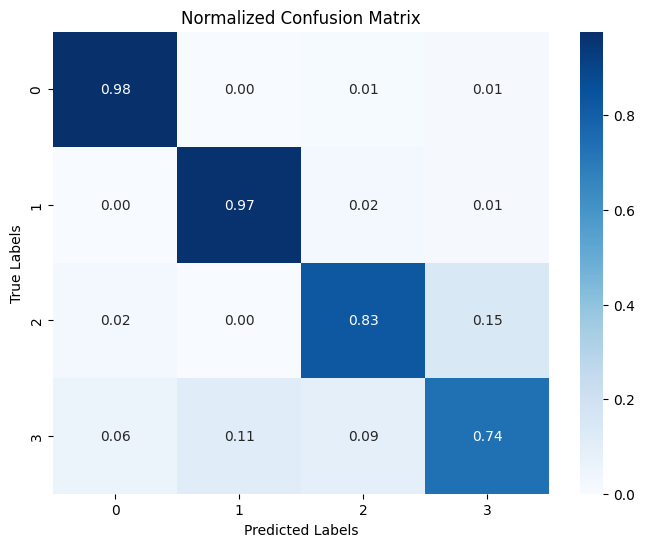

In [20]:
#confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Normalize the confusion matrix row-wise
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.xticks(ticks=np.arange(normalized_cm.shape[0]), labels=[str(i) for i in range(normalized_cm.shape[0])], rotation=0)
#plt.yticks(ticks=np.arange(normalized_cm.shape[0]), labels=[str(i) for i in range(normalized_cm.shape[0])], rotation=0)
plt.show()
